In [1]:
# import文一覧
#データ解析用ライブラリ
import pandas as pd
import numpy as np

#データ可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

#Xgboostライブラリ
import xgboost as xgb

#訓練データとモデル評価用データに分けるライブラリ
from sklearn.model_selection import train_test_split

#LavelEncoderのライブラリをインポート
from sklearn.preprocessing import LabelEncoder

In [2]:
#一通り評価指標をインポート
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

In [3]:
#csvデータの読み込み
sol_df = pd.read_csv('2015_winter_FP.csv')
sol_df = sol_df.drop('Cell_number', axis=1)
sol_df_copy = sol_df

In [85]:
#時系列データに変換するためにデータ型を文字列型に変換
sol_df_copy = sol_df_copy.astype({'year': 'str', 'month': 'str', 'day':'str', 'time':'str'})

In [86]:
#時系列データの作成
sol_df_copy['datetime'] = '200' + sol_df_copy['year'] + '-' + sol_df_copy['month'] + '-' + sol_df_copy['day'] + ' ' + sol_df_copy['time'] + ':00'

In [87]:
sol_df_copy['datetime'] =  pd.to_datetime(sol_df_copy['datetime']) 

In [88]:
sol_df = sol_df.dropna()

In [89]:
sol_df_copy = sol_df_copy.dropna()

In [90]:
# 終値を24時間分移動させる
sol_df_shift = sol_df_copy
sol_df_shift.EGC = sol_df_shift.EGC.shift(-24)

In [91]:
# 最後の行を除外
sol_df_shift = sol_df_shift[:-24]
 
# 念のためデータをdf_2として新しいデータフレームへコピ−
df_2 = sol_df_shift.copy()

In [92]:
xgb_params = {
    "learning_rate":0.05,
    "seed":4
}

In [93]:
#object型の変数を取得
categories = sol_df_shift.columns[sol_df_shift.dtypes == "object"]

In [97]:
#データ型を元に戻す
for cat in categories:
    sol_df_shift[cat] = sol_df_shift[cat].astype('int')

C:\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
#データの区分け
train_set, test_set = train_test_split(sol_df_shift, test_size=0.2, random_state=4, shuffle=False, stratify=None)

In [116]:
#データの確認
test_set

,year,month,day,time,peak_AM,peak_PM,Insolation,Temperature,Cloud_cover,Insolation_2,Exp_Insolation,Seek_number1,Seek_number2,EGC,Insolation_difference,Temperature_difference,datetime
1784,5,3,16,8,0.0,0.0,0.593,10.4,2.0,28.17,46280.2,301.1,37.47,3.6014,-0.006,2.3,2005-03-16 08:00:00
1785,5,3,16,9,0.0,0.0,0.587,12.7,2.0,27.61,45008.7,300.9,36.52,2.9585,0.131,1.8,2005-03-16 09:00:00
1786,5,3,16,10,0.0,0.0,0.718,14.5,2.0,32.98,53711.1,293.4,44.73,1.0523,0.229,2.5,2005-03-16 10:00:00
1787,5,3,16,11,1.0,0.0,0.947,17.0,9.0,41.23,67673.8,277.0,59.80,0.8736,-0.055,1.5,2005-03-16 11:00:00
1788,5,3,16,12,0.0,1.0,0.892,18.5,9.0,39.32,64599.0,276.0,57.36,1.3454,-0.176,0.3,2005-03-16 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,5,3,30,18,0.0,0.0,0.000,11.7,7.0,0.00,0.0,31.0,0.00,0.0000,0.000,-0.7,2005-03-30 18:00:00
2131,5,3,30,19,0.0,0.0,0.000,11.0,7.0,0.00,0.0,0.0,0.00,0.0000,0.000,-1.3,2005-03-30 19:00:00
2132,5,3,30,20,0.0,0.0,0.000,9.7,2.0,0.00,0.0,0.0,0.00,0.0000,0.000,-0.7,2005-03-30 20:00:00
2133,5,3,30,21,0.0,0.0,0.000,9.0,2.0,0.00,0.0,0.0,0.00,0.0000,0.000,-0.9,2005-03-30 21:00:00


In [117]:
#訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_train = train_set.drop(['EGC','datetime'], axis=1)
y_train = train_set['EGC']

In [118]:
#モデル評価用データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_test = test_set.drop(['EGC', 'datetime'], axis=1)
y_test = test_set['EGC']

In [119]:
#xgboost用データ
xgb_train = xgb.DMatrix(X_train,label=y_train)
xgb_eval = xgb.DMatrix(X_test, label=y_test)
evals = [(xgb_train, "train"), (xgb_eval, "eval")]

In [120]:
#モデル作成
model_xgb = xgb.train(xgb_params,
                      xgb_train,
                      evals=evals,
                      num_boost_round=1000,
                      early_stopping_rounds=20,
                      verbose_eval=10,)

[0]	train-rmse:5.76025	eval-rmse:5.89430
[10]	train-rmse:3.89973	eval-rmse:4.65356
[20]	train-rmse:2.84026	eval-rmse:4.04254
[30]	train-rmse:2.23367	eval-rmse:3.78874
[40]	train-rmse:1.86762	eval-rmse:3.71669
[50]	train-rmse:1.60869	eval-rmse:3.69909
[60]	train-rmse:1.42865	eval-rmse:3.72663
[70]	train-rmse:1.29381	eval-rmse:3.77248


In [121]:
y_pred = model_xgb.predict(xgb_eval)

In [122]:
#現状の予測値と実際の値の違いを可視化
actual_pred_df = pd.DataFrame({
    "actual":y_test,
    "pred":y_pred,
    "datetime":test_set['datetime']
})

In [123]:
pred_df = actual_pred_df.drop('datetime', axis=1)

In [158]:
#あらゆる指標の保存
RMSE = mse(pred_df['actual'], pred_df['pred'])
R2 = r2_score(pred_df['actual'], pred_df['pred'])
MAE = mae(pred_df['actual'], pred_df['pred'])
MAEP = MAE/pred_df['actual'].mean()
RMSEP = RMSE/pred_df['actual'].mean()

In [159]:
#for文を使って他の指標も作成
actual_1 = pred_df['actual'].values.tolist()
pred_1 = pred_df['pred'].values.tolist()

In [160]:
pred_df_copy = pred_df
pred_df_copy = pred_df_copy[pred_df_copy['actual'] != 0]

In [161]:
# 保留の指標
#MAPE = np.mean(np.abs((pred_df_copy['actual'] - pred_df_copy['pred'] / pred_df_copy['actual'])) * 100)
#RMSEP = np.sqrt(np.mean(((pred_df_copy['pred'] - pred_df_copy['actual']) / pred_df_copy['actual'])**2))*100

In [162]:
pred_df

,actual,pred
1784,3.6014,9.709208
1785,2.9585,8.300687
1786,1.0523,10.949615
1787,0.8736,15.026875
1788,1.3454,13.227265
...,...,...
2130,0.0000,0.019760
2131,0.0000,0.019760
2132,0.0000,0.019760
2133,0.0000,0.019760


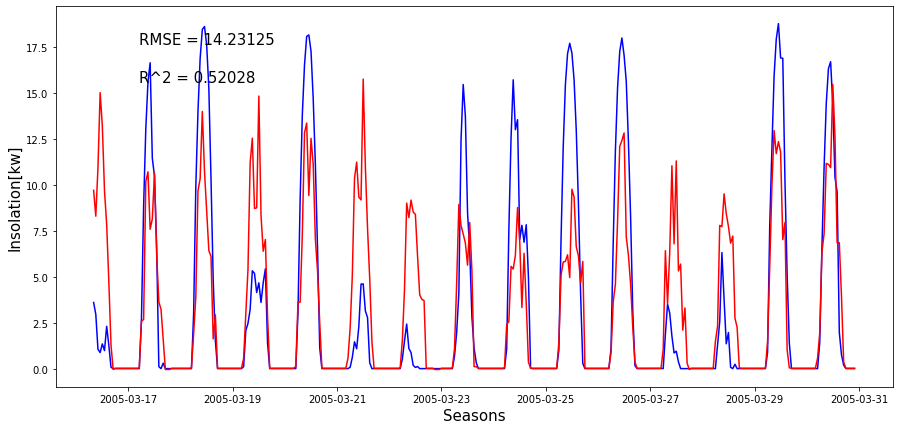

In [163]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
x = actual_pred_df['datetime']
y1 = pred_df['actual']
y2 = pred_df['pred']
ax.set_xlabel('Seasons', fontsize=15)
ax.set_ylabel('Insolation[kw]', fontsize=15)
ax.plot(x,y1,'b-')
ax.plot(x,y2,'r-')
plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
plt.show()

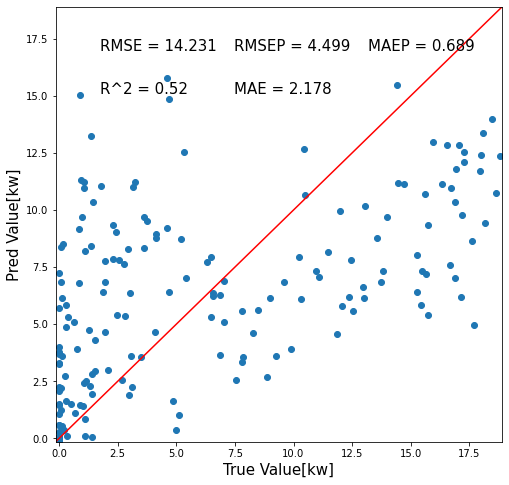

In [166]:
#R^2,RMSE
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter('actual', 'pred', data=pred_df)
ax.set_xlabel('True Value[kw]', fontsize=15)
ax.set_ylabel('Pred Value[kw]', fontsize=15)
ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
y = x
ax.plot(x,y,'r-')
plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 3))), transform=ax.transAxes, fontsize=15)
plt.text(0.4, 0.9, 'RMSEP = {}'.format(str(round(RMSEP, 3))), transform=ax.transAxes, fontsize=15)
plt.text(0.4, 0.8, 'MAE = {}'.format(str(round(MAE, 3))), transform=ax.transAxes, fontsize=15)
plt.text(0.7, 0.9, 'MAEP = {}'.format(str(round(MAEP, 3))), transform=ax.transAxes, fontsize=15)
plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 3))), transform=ax.transAxes, fontsize=15)

plt.show()